In [1]:
import qutip

In [2]:
#example code

#generate a spin ket
N = 3; J = N/2; m = -J
print("Total States: ", 2*J+1)
ket = qutip.spin_state(J,m)
print(ket)


Total States:  4.0
Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]


# Basis States

This problem is difficult to implement in QuTip without running into exponential scaling.

For this first iteration, we're going to run into it. As it's the easiest code to write.

Our basis states for the atoms are $\{\left|u\right>, \left|d\right>, \left|e\right>\}^{N}$.

In [3]:
u = qutip.basis(3,0)
d = qutip.basis(3,1)
e = qutip.basis(3,2)

#print out the basis states
# print("u: ", u)
# print("d: ", d)
# print("e: ", e)

id_atom = qutip.qeye(3)



Our cavity fock states are $\{0, 1, 2\}$

In [4]:
zero = qutip.basis(3,0)
one = qutip.basis(3,1)
two = qutip.basis(3,2)

id_cav = qutip.qeye(3)

Here we define the single-spin operators `sx`, `sy`, `sz` in terms of $\{\left|u\right>, \left|d\right>\}$.

In [5]:
#create the sx, sy, sz operators on the spin out of the u, d basis

sz = (u*u.dag() - d*d.dag())/2
sx = (u*d.dag() + d*u.dag())/2
sy = (u*d.dag() - d*u.dag())/(2*1j)

#make two atom spin operators
Natoms = 3

def make_natoms_operator(sx, id_atom, Natoms):
    array_of_identities = [id_atom,]*Natoms
    Sx = 0*qutip.tensor(*array_of_identities)
    for i in range(Natoms):
        temp = [id_atom,]*Natoms
        temp[i] = sx

        Sx = Sx + qutip.tensor(*temp)
    return Sx


sx = make_natoms_operator(sx, id_atom, Natoms)
sy = make_natoms_operator(sy, id_atom, Natoms)
sz = make_natoms_operator(sz, id_atom, Natoms)
    
#multiply by the identity on the cavity
sz = qutip.tensor(sz, id_cav)
sx = qutip.tensor(sx, id_cav)
sy = qutip.tensor(sy, id_cav)

id_atoms = qutip.tensor(*([id_atom,]*Natoms))

sx

Quantum object: dims = [[3, 3, 3, 3], [3, 3, 3, 3]], shape = (81, 81), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Here we define the single-excitation operators for down and up, `nu` and `mu`.

$\nu^\dag = \left| e \right>\left< u \right|$

$\mu^\dag = \left| e \right>\left< d \right|$

In [6]:
nu = u * e.dag()
mu = d * e.dag()

#make two atom excitation operators
nu = make_natoms_operator(nu, id_atom, Natoms)
mu = make_natoms_operator(mu, id_atom, Natoms)

#multiply by the identity on the cavity
mu = qutip.tensor(mu, id_cav)
nu = qutip.tensor(nu, id_cav)

Here we define the annihilation operator.

In [7]:
a = qutip.destroy(3)

#multiply by the identity on the spins
a = qutip.tensor(id_atoms, a)

Here we define the constants. We'll write everything in terms of 1 scale, the time constant of one of the matrix coefficients.

In [8]:
import numpy as np

Gamma_si = 180e3/2/np.pi
kappa_si = 500e3/2/np.pi
eta = 1.2276
g_si = 2*np.pi*eta*np.sqrt(Gamma_si*kappa_si)/4

#print a coupling constant in engineering notation
print(f"Atom Coupling Constant: {g_si:.2e} rad/s")

Atom Coupling Constant: 9.21e+04 rad/s


In [9]:
omega_si = 2*np.pi*5e6

# print(f"Optical Rabi Frequency: {omega:.2e} rad/s")

Here we define the rescaled coefficients.

In [10]:
scale = kappa_si


g = g_si/scale
kappa = kappa_si/scale
Gamma = Gamma_si/scale
omega = omega_si/scale
omega = kappa*3.28688
# Lambda = 0.1*kappa
detuning = -9.6703*kappa
Lambda = 1*kappa
# Lambda = g
#print parameters
print("g: ", g)
print("detuning: ", detuning)
print("Kappa: ", kappa)
print("Gamma: ", Gamma)
print("omega: ", omega)
print("Lambda: ", Lambda)

g:  1.156985742464049
detuning:  -9.6703
Kappa:  1.0
Gamma:  0.36
omega:  3.28688
Lambda:  1.0


Here we define the Hamiltonian

In [11]:
def H(t,args):
    try:
        w = args['w']
    except:
        w = 0
    Hpart = g*(a*nu.dag()*np.cos(omega*t)- 1j*a*mu.dag()*np.sin(omega*t)) + Lambda*(np.exp(1j*w*t)*a)

    Ht = Hpart + Hpart.dag()
    return Ht

# Initial State 

In [12]:
# dd = qutip.tensor([(1/np.sqrt(2))*(u-d),]*Natoms); spin_state = 'x' #x state
dd = qutip.tensor([(1/np.sqrt(2))*(u-1j*d),]*Natoms); spin_state = 'y' #y state
# dd = qutip.tensor([(d),]*Natoms); spin_state='z' #z state
# dd = qutip.tensor(d,d)
# dd = qutip.tensor(d,d)
psi0 = qutip.tensor(dd, zero)
rho0 = psi0*psi0.dag()
rho0


Quantum object: dims = [[3, 3, 3, 3], [3, 3, 3, 3]], shape = (81, 81), type = oper, isherm = True
Qobj data =
[[0.125+0.j 0.   +0.j 0.   +0.j ... 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j ... 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j ... 0.   +0.j 0.   +0.j 0.   +0.j]
 ...
 [0.   +0.j 0.   +0.j 0.   +0.j ... 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j ... 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j ... 0.   +0.j 0.   +0.j 0.   +0.j]]

In [13]:
id_spin = u*u.dag() + d*d.dag()

id_spin = qutip.tensor(*[id_spin,]*Natoms, id_cav)
id_spin

Quantum object: dims = [[3, 3, 3, 3], [3, 3, 3, 3]], shape = (81, 81), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [14]:
cavity_decay = a*np.sqrt(kappa)
atom_decay = nu*np.sqrt(Gamma)
atom_decay

Quantum object: dims = [[3, 3, 3, 3], [3, 3, 3, 3]], shape = (81, 81), type = oper, isherm = False
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [15]:
from qutip import mesolve
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar

print(rho0.dims)
print(cavity_decay.dims)
print(atom_decay.dims)
print(sx.dims)
print(sy.dims)
print(sz.dims)

opts = qutip.solver.Options(nsteps=12000)
T = 360
solution = mesolve(
    H=H,
    rho0=rho0,
    tlist=np.linspace(0, T*2*np.pi/kappa/10, 100),
    c_ops=[cavity_decay,atom_decay],
    e_ops=None,
    args={'w': detuning},
    options=opts,
    progress_bar=TextProgressBar()
)

states = solution.states
e_ops = [sx, sy, sz, sx*sx, sy*sy, sz*sz, id_spin, a.dag()*a, sy*sz+sz*sy, sz*sx + sx*sz, sx*sy + sy*sz]
e_vals = [np.array([qutip.expect(e_op, state) for state in states]) for e_op in e_ops]


[[3, 3, 3, 3], [3, 3, 3, 3]]
[[3, 3, 3, 3], [3, 3, 3, 3]]
[[3, 3, 3, 3], [3, 3, 3, 3]]
[[3, 3, 3, 3], [3, 3, 3, 3]]
[[3, 3, 3, 3], [3, 3, 3, 3]]
[[3, 3, 3, 3], [3, 3, 3, 3]]
10.0%. Run time:   7.95s. Est. time left: 00:00:01:11
20.0%. Run time:  16.13s. Est. time left: 00:00:01:04
30.0%. Run time:  23.93s. Est. time left: 00:00:00:55
40.0%. Run time:  31.72s. Est. time left: 00:00:00:47
50.0%. Run time:  39.49s. Est. time left: 00:00:00:39
60.0%. Run time:  47.16s. Est. time left: 00:00:00:31
70.0%. Run time:  54.76s. Est. time left: 00:00:00:23
80.0%. Run time:  62.41s. Est. time left: 00:00:00:15
90.0%. Run time:  70.12s. Est. time left: 00:00:00:07
Total run time:  77.08s


In [16]:
#plot sx*sx

import matplotlib.pyplot as plt

sx, sy, sz, sxx, syy, szz, norm, photons, syz, szx, sxy = e_vals

szy = syz
sxz = szx
syx = sxy

t = solution.times
states = solution.states
# print(states)
entropy = [qutip.entropy_vn(states[i]) for i in range(len(states))]
# print(entropy)


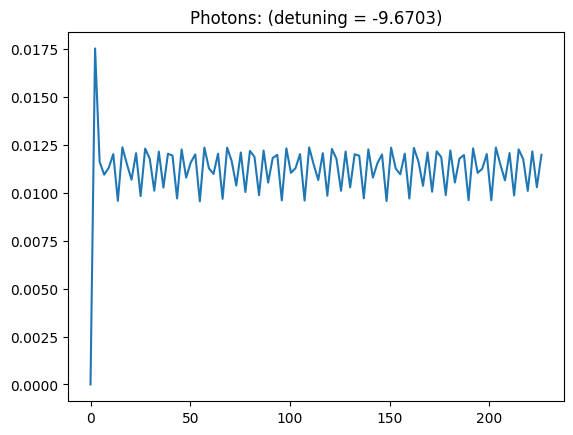

In [17]:
#plot photon number
plt.plot(solution.times, photons);
plt.title(f"Photons: (detuning = {detuning})");

Text(0.5, 1.0, 'psi0 = y, Variance (detuning = -9.67, omega=3.29, kappa=1.0)\nphotons = 0.0112, lambda = 1.0')

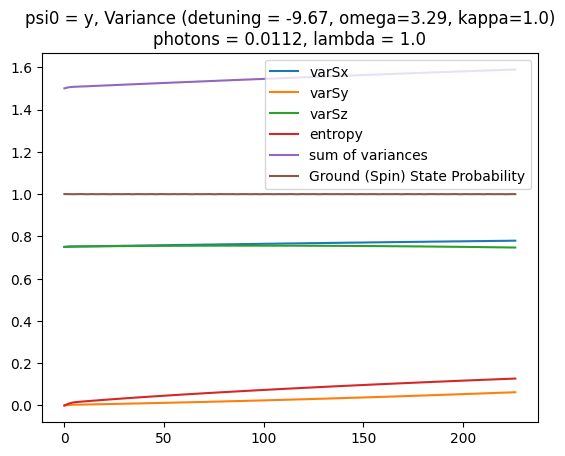

In [18]:
#plot sx variance
plt.plot(t, sxx - sx**2, label="varSx");
plt.plot(t, syy - sy**2, label="varSy");
plt.plot(t, szz - sz**2, label="varSz");
plt.plot(t, entropy, label="entropy")
plt.plot(t, sxx+syy+szz- sx**2 - sy**2 - sz**2, label="sum of variances")
plt.plot(t, norm, label="Ground (Spin) State Probability")
plt.legend();
plt.title(f"psi0 = {spin_state}, Variance (detuning = {detuning:0.3}, omega={omega:0.3}, kappa={kappa:0.3})\nphotons = {np.mean(photons):0.3}, lambda = {Lambda:0.3}")

In [19]:
def rotated_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis, angle):
    """Calculates the rotated moments over time of a spin-1/2 system from its expectation values of spin operators.
    
    Args:
        sx (ndarray): Array of expectation values of sigma_x.
        sy (ndarray): Array of expectation values of sigma_y.
        sz (ndarray): Array of expectation values of sigma_z.
        sxx (float): Expectation value of sigma_x^2.
        syy (float): Expectation value of sigma_y^2.
        szz (float): Expectation value of sigma_z^2.
        axis (ndarray): String defining the rotation axis 'x', 'y', 'z'.
        angle (float): Angle of rotation in radians.
        
    Returns:
        float: The rotated variance.
    """
    
    if axis == 'x' or axis == 'X':
        s0  = sy
        s1  = sz
        s01 = sxy
        s00 = syy
        s11 = szz
    elif axis == 'y' or axis == 'Y':
        s0  = sz
        s1  = sx
        s01 = szx
        s00 = szz
        s11 = sxx
    elif axis == 'z' or axis == 'Z':
        s0  = sx
        s1  = sy
        s01 = sxy
        s00 = sxx
        s11 = syy
    else:
        raise ValueError("Invalid rotation axis. Must be 'x', 'y', or 'z'.")
        
    
    #calculate the rotation moments sa, saa, sb, sbb. For 'x', sa = s0, sb = s1 at no rotation
    #sa = s0*cos(angle) + s1*sin(angle)
    #saa = s00*cos(angle)^2 + s11*sin(angle)^2 + (s01+s10)*cos(angle)*sin(angle).
    
    c = np.cos(angle)
    s = np.sin(angle)
    
    sa = s0 * c + s1 * s
    sb = -s0 * s + s1 * c
    
    saa = s00 * c ** 2 + s11 * s ** 2 +  s01 * c * s
    sbb = s00 * s ** 2 + s11 * c ** 2 -  s01 * c * s
    
    #return the variances over time
    return (saa - sa**2, sbb - sb**2)
     
def max_min_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis):
    variances = []
    for angle in np.linspace(0,2*np.pi, 180):
        x,y = rotated_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis, angle)
        
        variances.append(x)
        
    #convert this to a numpy array
    variances = np.array(variances)


    #and take max over the new dimension
    max_variance_over_time = np.max(variances, axis=0)
    min_variance_over_time = np.min(variances, axis=0)
        
        
    return max_variance_over_time, min_variance_over_time
        
        

Text(0.5, 1.0, 'psi0 = y, Variance (detuning = -9.67, omega=3.29, kappa=1.0)\nphotons = 0.0112, lambda = 1.0')

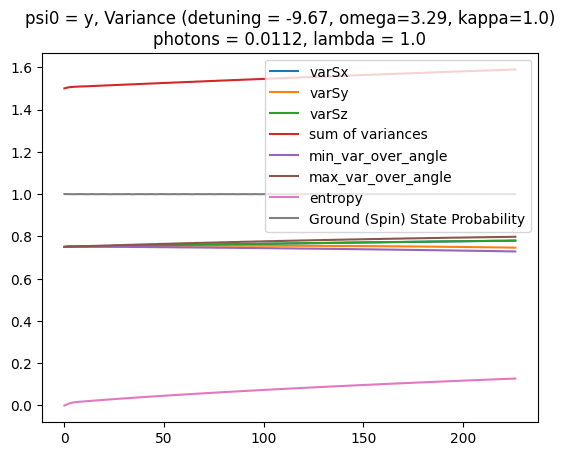

In [20]:
#rotate the variances about sx
angle = 0.01
axis = 'Y'
syyp, szzp = rotated_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis, angle)
s_maxmax, s_minmin  = max_min_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis)
#plot sx variance
plt.plot(t, sxx - sx**2, label="varSx");
plt.plot(t, syyp, label="varSy");
plt.plot(t, szzp, label="varSz");
plt.plot(t, sxx+syy+szz- sx**2 - sy**2 - sz**2, label="sum of variances")
plt.plot(t, s_minmin, label="min_var_over_angle")
plt.plot(t, s_maxmax, label="max_var_over_angle")
plt.plot(t, entropy, label="entropy")
plt.plot(t, norm, label="Ground (Spin) State Probability")
plt.legend();
plt.title(f"psi0 = {spin_state}, Variance (detuning = {detuning:0.3}, omega={omega:0.3}, kappa={kappa:0.3})\nphotons = {np.mean(photons):0.3}, lambda = {Lambda:0.3}")

Text(0.5, 1.0, 'psi0 = y, Variance (detuning = -9.67, omega=3.29, kappa=1.0)\nphotons = 0.0112, lambda = 1.0')

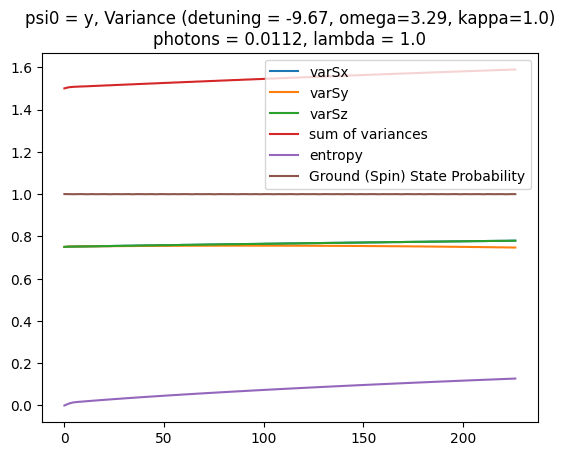

In [21]:
# Create the initial plot with alpha=0
angle = 0
axis = 'Y'
syyp, szzp = rotated_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis, angle)
s_maxmax, s_minmin  = max_min_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis)
fig, ax = plt.subplots()
ax.plot(t, sxx - sx**2, label="varSx")
ax.plot(t, syyp, label="varSy")
ax.plot(t, szzp, label="varSz")
ax.plot(t, sxx + syy + szz - sx**2 - sy**2 - sz**2, label="sum of variances")
ax.plot(t, entropy, label="entropy")
ax.plot(t, norm, label="Ground (Spin) State Probability")
ax.legend()
ax.set_title(f"psi0 = {spin_state}, Variance (detuning = {detuning:0.3}, omega={omega:0.3}, kappa={kappa:0.3})\nphotons = {np.mean(photons):0.3}, lambda = {Lambda:0.3}")


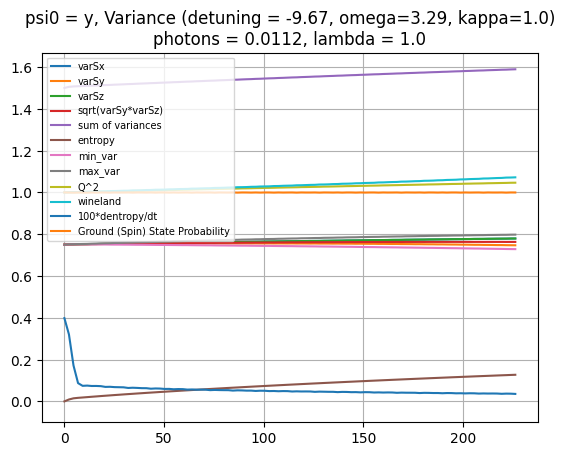

FloatSlider(value=0.0, description='Alpha', max=360.0, step=5.0)

Rotation Axis = Y


In [22]:
axis = 'Y'

fs = 7 #fontsize
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define the function to calculate the rotated variances

# Create a new cell with the slider widget and display it
slider = widgets.FloatSlider(min=0, max=360, step=5, value=0, description='Alpha')
s_maxmax, s_minmin  = max_min_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis)

# Define the function to update the plot based on the slider value
def update(alpha, slider=slider,axis=axis):
    clear_output(wait=True)  # clear the previous output
    
    angle = alpha * np.pi / 180  # convert degrees to radians
    syyp, szzp = rotated_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis, angle)
    fig, ax = plt.subplots()
    ax.plot(t, sxx - sx**2, label="varSx")
    ax.plot(t, syyp, label="varSy")
    ax.plot(t, szzp, label="varSz")
    ax.plot(t,np.sqrt(syyp*szzp), label='sqrt(varSy*varSz)')
    ax.plot(t, sxx + syy + szz - sx**2 - sy**2 - sz**2, label="sum of variances")
    ax.plot(t, entropy, label="entropy")
    ax.plot(t, s_minmin, label ='min_var')
    ax.plot(t, s_maxmax, label ='max_var')
    ax.plot(t, np.sqrt(s_maxmax/s_minmin), label='Q^2')
    ax.plot(t, 100*np.gradient(entropy, t), label="100*dentropy/dt")
    ax.plot(t, norm, label="Ground (Spin) State Probability")
    ax.set_ylim(-0.1,None)
#     ax.legend()
    ax.legend(fontsize=fs)
    ax.set_title(f"psi0 = {spin_state}, Variance (detuning = {detuning:0.3}, omega={omega:0.3}, kappa={kappa:0.3})\nphotons = {np.mean(photons):0.3}, lambda = {Lambda:0.3}")
    ax.grid(True)
    
    plt.show()
    display(slider)
    print(f"Rotation Axis = {axis}")


# Define the initial plot with alpha=0
angle = 0
axis = 'Y'
syyp, szzp = rotated_variance(sx, sy, sz, sxy, syz, szx, sxx, syy, szz, axis, angle)

#calculate the wineland paramater
stdVar = Natoms/4
Qsq = np.sqrt(s_maxmax/s_minmin)
contrast = np.sqrt(sx**2 + sy**2 + sz**2)/(N/2)
area = np.sqrt(s_maxmax*s_minmin)/stdVar
wineland_parameter = Qsq/(contrast**2 * area)


fig, ax = plt.subplots()
ax.plot(t, sxx - sx**2, label="varSx")
ax.plot(t, syyp, label="varSy")
ax.plot(t, szzp, label="varSz")
ax.plot(t,np.sqrt(syyp*szzp), label='sqrt(varSy*varSz)')
ax.plot(t, sxx + syy + szz - sx**2 - sy**2 - sz**2, label="sum of variances")
ax.plot(t, entropy, label="entropy")
ax.plot(t, s_minmin, label ='min_var')
ax.plot(t, s_maxmax, label ='max_var')
ax.plot(t, Qsq, label='Q^2')
ax.plot(t, wineland_parameter, label='wineland')
ax.plot(t, 100*np.gradient(entropy, t), label="100*dentropy/dt")
ax.plot(t, norm, label="Ground (Spin) State Probability")
ax.set_ylim(-0.1,None)

ax.legend(fontsize=fs)
ax.set_title(f"psi0 = {spin_state}, Variance (detuning = {detuning:0.3}, omega={omega:0.3}, kappa={kappa:0.3})\nphotons = {np.mean(photons):0.3}, lambda = {Lambda:0.3}")
ax.grid(True)
plt.show()
display(slider)
print(f"Rotation Axis = {axis}")

# Connect the slider to the update function using the observe method
slider.observe(lambda change: update(change.new), names='value')


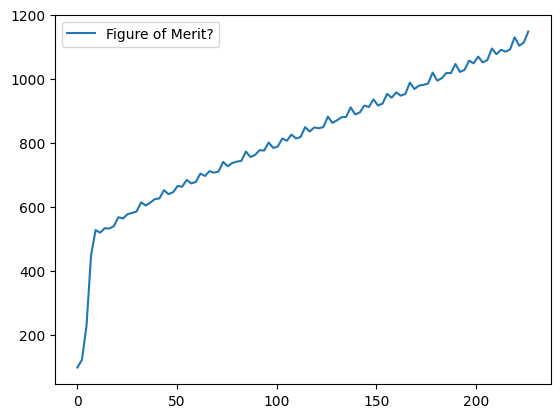

In [23]:
#I want to plot the Q^2/integrated photon number*dS/dt

Qsq = np.sqrt(s_maxmax/s_minmin)
int_photon = np.trapz(photons, t)
dSdt = np.gradient(entropy, t)

plt.plot(t, Qsq/(int_photon*dSdt), label="Figure of Merit?")
plt.legend()



In [24]:
%%html
<style>
div.output_scroll {
    max-height: 1000px;
    min-height: 600px;
    overflow-y: auto;
}
</style>